In [50]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import matplotlib
# matplotlib.use("pgf")
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap
import seaborn as sns

In [51]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.369422,0.078324,0.000444,0.009978,0.724212,0.014852,0.008606,0.015570,0.009878,0.001069,0.011646,0.112122,0.257314,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.453125,0.025104,0.000232,0.009977,0.045600,0.019498,0.001095,0.011275,0.009880,0.009658,0.009361,0.009878,0.000904,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.343750,0.000896,0.000248,0.009981,0.009991,0.009826,0.000248,0.000808,0.001119,0.000480,0.001412,0.000899,0.000248,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,0.328125,0.008395,0.000234,0.009978,0.047617,0.038203,0.027087,0.009841,0.009859,0.009885,0.007653,0.000234,0.006513,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.375000,0.038187,0.000241,0.009978,0.036785,0.009870,0.000475,0.000475,0.034847,0.000475,0.000475,0.000241,0.000475,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535036,0.500000,0.000000,0.000239,0.010094,0.010094,0.010094,0.010094,0.002523,0.003694,0.003694,0.010094,0.000239,0.002523,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535037,0.437500,0.046875,0.000235,0.010094,12.029791,0.010094,0.000474,0.010094,0.010094,0.000235,0.010094,0.010094,0.327832,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535038,0.484375,0.015625,0.000234,0.010092,0.039899,0.039899,0.004163,0.010092,0.010092,0.010092,0.010092,0.010092,0.000469,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535039,0.453125,0.000000,0.000232,0.010092,0.010092,0.010092,0.010092,0.010092,0.010092,0.010092,0.010092,0.000701,0.006558,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0


In [52]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [53]:
from sklearn.preprocessing import StandardScaler, RobustScaler

feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

for col in feature_columns:
    scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns ==col] = scaler.transform(df.loc[:, df.columns == col])

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.091860,0.602552,12.635966,-0.032347,1.032490,0.650084,0.579584,1.515106,0.742259,-0.751403,0.305685,12.096536,3.719217,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.857143,-0.078674,-0.626866,-0.033724,0.008422,1.171925,-0.216700,1.070032,0.742429,0.092042,0.063812,0.995349,-0.010985,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,-0.142857,-0.388528,0.373134,-0.030027,-0.045314,0.085632,-0.306483,-0.014649,-0.180291,-0.809219,-0.777600,0.020368,-0.020530,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,-0.285714,-0.292542,-0.492537,-0.032380,0.011465,3.272805,2.538769,0.921470,0.740210,0.114304,-0.117011,-0.051799,0.070607,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.142857,0.088797,-0.074627,-0.032380,-0.004880,0.090571,-0.282421,-0.049116,3.372000,-0.809711,-0.876792,-0.051074,-0.017228,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535036,1.285714,-0.400000,-0.179104,0.064176,-0.045159,0.115711,0.737318,0.163134,0.090901,-0.493609,0.141429,-0.051256,0.012570,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535037,0.714286,0.200000,-0.447761,0.063978,18.093316,0.115684,-0.282522,0.947648,0.764950,-0.833287,0.141404,1.018742,4.745096,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535038,1.142857,-0.200000,-0.492537,0.062388,-0.000181,3.463353,0.108556,0.947450,0.764749,0.134640,0.141202,1.018535,-0.017315,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535039,0.857143,-0.400000,-0.626866,0.062388,-0.045162,0.115470,0.737091,0.947450,0.764749,0.134640,0.141202,-0.001113,0.071267,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0


In [54]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [55]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		46527		19987
Attack		46527		19987


In [56]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

Deep Neural Network

In [57]:
import keras
from keras import layers

dnn = keras.models.Sequential(
    [
        layers.Dense(23, activation='relu', input_dim=len(X_train.columns)),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

dnn.compile(
    optimizer="adam",  # Optimizer rmsprop
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.FalseNegatives()],
)

X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

dnn.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=3,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
)

# results = dnn.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

Epoch 1/3
2596/2596 [==============================] - 3s 1ms/step - loss: 0.1431 - binary_accuracy: 0.9647 - recall_14: 0.9554 - false_negatives_14: 1628.0000 - val_loss: 0.0544 - val_binary_accuracy: 0.9751 - val_recall_14: 0.9751 - val_false_negatives_14: 249.0000
Epoch 2/3
2596/2596 [==============================] - 3s 1ms/step - loss: 0.0335 - binary_accuracy: 0.9909 - recall_14: 0.9847 - false_negatives_14: 560.0000 - val_loss: 0.0296 - val_binary_accuracy: 0.9881 - val_recall_14: 0.9881 - val_false_negatives_14: 119.0000
Epoch 3/3
2596/2596 [==============================] - 3s 1ms/step - loss: 0.0244 - binary_accuracy: 0.9952 - recall_14: 0.9935 - false_negatives_14: 239.0000 - val_loss: 0.0209 - val_binary_accuracy: 0.9946 - val_recall_14: 0.9946 - val_false_negatives_14: 54.0000


In [58]:
y_pred = np.round(dnn.predict(X_test))

f1_scores = f1_score(y_test, y_pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, y_pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Testing F1:  0.9965(+/- 0.0000)
Kappa score:  0.9930(+/- 0.0000)


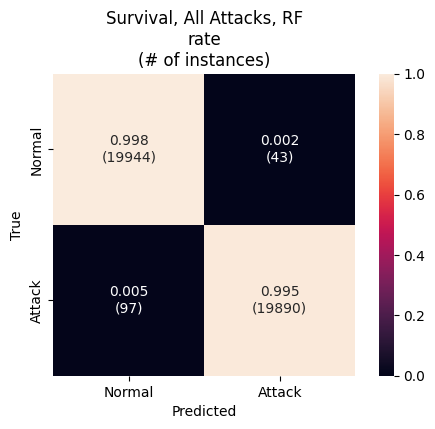

In [59]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred, "Survival, All Attacks, RF\nrate\n(# of instances)")